# Movie Data Analysis with PySpark

## Setup and Imports

In [62]:
# Add the parent directory to sys.path to import from src
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import necessary libraries
import json
from dotenv import load_dotenv
from pyspark.sql import functions as F

# Import project modules
from src.data_extraction import initialize_spark, fetch_all_movies, create_spark_dataframe

# Load environment variables
load_dotenv()

# Access API token from environment variable
API_ACCESS_TOKEN = os.getenv('API_ACCESS_TOKEN')
BASE_URL = "https://api.themoviedb.org/3/movie"

print("Setup complete")


Setup complete


## Initialize Spark Session

In [63]:
# Initialize Spark session
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = initialize_spark(app_name="Movie Data Analysis")
print(f"PySpark version: {spark.version}")



2025-04-25 15:53:17,800 - src.data_extraction - INFO - PySpark session initialized: version 3.5.5


PySpark version: 3.5.5


## Step 1: Fetch Movie Data from API

In [64]:
# List of movie IDs to fetch (as specified in the project requirements)
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428,
             168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445,
             321612, 260513]

# Fetch movie data from API
all_movies_data = fetch_all_movies(movie_ids, BASE_URL, API_ACCESS_TOKEN)

# Save raw data to JSON file for backup
with open("../data/movies_raw.json", "w") as json_file:
    json.dump(all_movies_data, json_file, indent=4)
print(f"Raw data saved to file, fetched {len(all_movies_data)} movies")

# Convert movie data to PySpark DataFrame
movies_df = spark.read.option("multiline", "true").json("../data/movies_raw.json")


# Display schema to understand the data structure
movies_df.printSchema()

# Display a sample of the data
movies_df.select("adult", "budget", "id").show(5, truncate=False)



2025-04-25 15:53:17,826 - src.data_extraction - INFO - Fetching data for 19 movies
2025-04-25 15:53:18,239 - src.data_extraction - ERROR - Error 404 for movie_id=0
2025-04-25 15:53:18,469 - src.data_extraction - INFO - Successfully fetched data for movie_id=299534
2025-04-25 15:53:18,690 - src.data_extraction - INFO - Successfully fetched data for movie_id=19995
2025-04-25 15:53:18,885 - src.data_extraction - INFO - Successfully fetched data for movie_id=140607
2025-04-25 15:53:19,130 - src.data_extraction - INFO - Successfully fetched data for movie_id=299536
2025-04-25 15:53:19,338 - src.data_extraction - INFO - Successfully fetched data for movie_id=597
2025-04-25 15:53:19,521 - src.data_extraction - INFO - Successfully fetched data for movie_id=135397
2025-04-25 15:53:19,713 - src.data_extraction - INFO - Successfully fetched data for movie_id=420818
2025-04-25 15:53:19,919 - src.data_extraction - INFO - Successfully fetched data for movie_id=24428
2025-04-25 15:53:20,124 - src.dat

Raw data saved to file, fetched 18 movies
root
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: struct (nullable = true)
 |    |-- backdrop_path: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- poster_path: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- credits: struct (nullable = true)
 |    |-- cast: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- adult: boolean (nullable = true)
 |    |    |    |-- cast_id: long (nullable = true)
 |    |    |    |-- character: string (nullable = true)
 |    |    |    |-- credit_id: string (nullable = true)
 |    |    |    |-- gender: long (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- known_for_department: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- order: long (nullabl

In [65]:
# Cache the DataFrame for better performance in subsequent operations
movies_df.cache()

# Save DataFrame in Parquet format (efficient for later loading)
# movies_df.write.mode("overwrite").parquet("../data/movies_raw.parquet")
# print("DataFrame saved to Parquet file")


DataFrame[adult: boolean, backdrop_path: string, belongs_to_collection: struct<backdrop_path:string,id:bigint,name:string,poster_path:string>, budget: bigint, credits: struct<cast:array<struct<adult:boolean,cast_id:bigint,character:string,credit_id:string,gender:bigint,id:bigint,known_for_department:string,name:string,order:bigint,original_name:string,popularity:double,profile_path:string>>,crew:array<struct<adult:boolean,credit_id:string,department:string,gender:bigint,id:bigint,job:string,known_for_department:string,name:string,original_name:string,popularity:double,profile_path:string>>>, genres: array<struct<id:bigint,name:string>>, homepage: string, id: bigint, imdb_id: string, origin_country: array<string>, original_language: string, original_title: string, overview: string, popularity: double, poster_path: string, production_companies: array<struct<id:bigint,logo_path:string,name:string,origin_country:string>>, production_countries: array<struct<iso_3166_1:string,name:string>>, 

In [66]:
# Define constants
COLUMNS_TO_DROP = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
FINAL_COLUMN_ORDER = [
    'id', 'title', 'tagline', 'release_date', 'genre_names', 'collection_name',
    'original_language', 'budget_musd', 'revenue_musd', 'production_companies_names',
    'production_countries_names', 'vote_count', 'vote_average', 'popularity', 'runtime',
    'overview', 'spoken_languages_names', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size'
]

## Step 2: Data Cleaning and Preprocessing

### Process and Clean the Data

In [67]:
from src.data_preprocessing import preprocess_movie_data

In [68]:
# Process the raw movie data through the complete preprocessing pipeline
cleaned_df = preprocess_movie_data(movies_df, COLUMNS_TO_DROP, FINAL_COLUMN_ORDER)

2025-04-25 15:53:23,615 - src.data_preprocessing - INFO - Starting preprocessing pipeline
2025-04-25 15:53:23,629 - src.data_preprocessing - INFO - Dropped columns: ['adult', 'imdb_id', 'original_title', 'video', 'homepage']


Extracting name from belongs_to_collection to collection_name
Extracting name from genres to genre_names
Extracting name from production_countries to production_countries_names
Extracting name from production_companies to production_companies_names
Extracting english_name from spoken_languages to spoken_languages_names
Processing credits: extract_names from credits to cast
Processing credits: count_members from credits to cast_size
Processing credits: extract_by_job from credits to director


2025-04-25 15:53:23,878 - src.data_preprocessing - INFO - Converting column data types


Processing credits: count_members from credits to crew_size


2025-04-25 15:53:24,061 - src.data_preprocessing - INFO - Successfully converted column data types
2025-04-25 15:53:24,074 - src.data_preprocessing - INFO - Handling missing and incorrect data
2025-04-25 15:53:24,546 - src.data_preprocessing - INFO - Successfully handled missing and incorrect data
2025-04-25 15:53:24,551 - src.data_preprocessing - INFO - Organizing final DataFrame
2025-04-25 15:53:24,771 - src.data_preprocessing - INFO - Final DataFrame has 18 rows and 22 columns
2025-04-25 15:53:24,773 - src.data_preprocessing - INFO - Preprocessing pipeline completed successfully


### 2.2 Examine the Preprocessed Data

In [69]:
# Display the schema of the preprocessed DataFrame
cleaned_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- genre_names: string (nullable = false)
 |-- collection_name: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- budget_musd: double (nullable = true)
 |-- revenue_musd: double (nullable = true)
 |-- production_companies_names: string (nullable = false)
 |-- production_countries_names: string (nullable = false)
 |-- vote_count: integer (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- overview: string (nullable = true)
 |-- spoken_languages_names: string (nullable = false)
 |-- poster_path: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- cast_size: integer (nullable = true)
 |-- director: string (nullable = true)
 |-- crew_size: integer (nullable = true)



In [70]:
# Show a sample of the cleaned data
cleaned_df.show(5)

# cleaned_df.select("cast_size", "director", "crew_size", "cast").show(truncate=False)


# cleaned_df.select("title", "collection_name", "genre_names", "cast").show(5, truncate=False)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------------+--------------------------+----------+------------+----------+-------+--------------------+----------------------+--------------------+--------------------+---------+--------------------+---------+
|    id|               title|             tagline|release_date|         genre_names|     collection_name|original_language|budget_musd|revenue_musd|production_companies_names|production_countries_names|vote_count|vote_average|popularity|runtime|            overview|spoken_languages_names|         poster_path|                cast|cast_size|            director|crew_size|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------------+--------------------------+----------+------------+----------+-------+---------

## Step 3: KPI Implementation & Analysis

In [71]:
from src.analysis import *

In [72]:
# Register the DataFrame as a temporary SQL table for SQL-based analysis
cleaned_df.createOrReplaceTempView("movies")

### Calculate financial metrics (profit and ROI)

In [73]:
movies_df = calculate_financial_metrics(cleaned_df)
print("Financial metrics calculated")

2025-04-25 15:53:25,162 - src.analysis - INFO - Calculating financial metrics
2025-04-25 15:53:25,206 - src.analysis - INFO - Successfully calculated financial metrics


Financial metrics calculated


### Highest Revenue Movies

In [74]:
highest_revenue = get_highest_revenue_movies(movies_df)
print("\nHighest Revenue Movies:")
highest_revenue.select("title", "release_date", "revenue_musd").show(5)

2025-04-25 15:53:25,231 - src.analysis - INFO - Finding top 10 highest revenue movies



Highest Revenue Movies:
+--------------------+------------+------------+
|               title|release_date|revenue_musd|
+--------------------+------------+------------+
|              Avatar|  2009-12-15| 2923.706026|
|   Avengers: Endgame|  2019-04-24|   2799.4391|
|             Titanic|  1997-11-18| 2264.162353|
|Star Wars: The Fo...|  2015-12-15| 2068.223624|
|Avengers: Infinit...|  2018-04-25| 2052.415039|
+--------------------+------------+------------+
only showing top 5 rows



### Highest Budget Movies

In [75]:
highest_budget = get_highest_budget_movies(movies_df)
print("\nHighest Budget Movies:")
highest_budget.select("title", "release_date", "budget_musd").show(5)

2025-04-25 15:53:25,432 - src.analysis - INFO - Finding top 10 highest budget movies



Highest Budget Movies:
+--------------------+------------+-----------+
|               title|release_date|budget_musd|
+--------------------+------------+-----------+
|Avengers: Age of ...|  2015-04-22|      365.0|
|   Avengers: Endgame|  2019-04-24|      356.0|
|Avengers: Infinit...|  2018-04-25|      300.0|
|       The Lion King|  2019-07-12|      260.0|
|Star Wars: The Fo...|  2015-12-15|      245.0|
+--------------------+------------+-----------+
only showing top 5 rows



### Highest Profit Movies

In [76]:
highest_profit = get_highest_profit_movies(movies_df)
print("\nHighest Profit Movies:")
highest_profit.select("title", "budget_musd", "revenue_musd", "profit_musd").show(5)

2025-04-25 15:53:25,626 - src.analysis - INFO - Finding top 10 highest profit movies



Highest Profit Movies:
+--------------------+-----------+------------+------------------+
|               title|budget_musd|revenue_musd|       profit_musd|
+--------------------+-----------+------------+------------------+
|              Avatar|      237.0| 2923.706026|       2686.706026|
|   Avengers: Endgame|      356.0|   2799.4391|         2443.4391|
|             Titanic|      200.0| 2264.162353|       2064.162353|
|Star Wars: The Fo...|      245.0| 2068.223624|1823.2236240000002|
|Avengers: Infinit...|      300.0| 2052.415039|       1752.415039|
+--------------------+-----------+------------+------------------+
only showing top 5 rows



### Lowest Profit Movies


In [77]:
lowest_profit = get_lowest_profit_movies(movies_df)
print("\nLowest Profit Movies:")
lowest_profit.select("title", "budget_musd", "revenue_musd", "profit_musd").show(5)

2025-04-25 15:53:25,827 - src.analysis - INFO - Finding top 10 lowest profit movies



Lowest Profit Movies:
+--------------------+-----------+------------+-----------+
|               title|budget_musd|revenue_musd|profit_musd|
+--------------------+-----------+------------+-----------+
|Avengers: Age of ...|      365.0| 1405.403694|1040.403694|
|       Incredibles 2|      200.0| 1242.805359|1042.805359|
|Beauty and the Beast|      160.0| 1266.115964|1106.115964|
|              Frozen|      150.0| 1274.219009|1124.219009|
|Star Wars: The La...|      200.0|  1332.69883| 1132.69883|
+--------------------+-----------+------------+-----------+
only showing top 5 rows



### Highest ROI Movies

In [78]:
highest_roi = get_highest_roi_movies(movies_df)
print("\nHighest ROI Movies (Budget >= 10M):")
highest_roi.select("title", "budget_musd", "revenue_musd", "roi").show(5)

2025-04-25 15:53:26,101 - src.analysis - INFO - Finding top 10 highest ROI movies (budget >= 10M)



Highest ROI Movies (Budget >= 10M):
+--------------------+-----------+------------+-----------------+
|               title|budget_musd|revenue_musd|              roi|
+--------------------+-----------+------------+-----------------+
|              Avatar|      237.0| 2923.706026|12.33631234599156|
|             Titanic|      200.0| 2264.162353|     11.320811765|
|      Jurassic World|      150.0| 1671.537444|      11.14358296|
|Harry Potter and ...|      125.0| 1341.511219|     10.732089752|
|           Frozen II|      150.0| 1453.683476|9.691223173333332|
+--------------------+-----------+------------+-----------------+
only showing top 5 rows



### Lowest ROI Movies

In [79]:
lowest_roi = get_lowest_roi_movies(movies_df)
print("\nLowest ROI Movies (Budget >= 10M):")
lowest_roi.select("title", "budget_musd", "revenue_musd", "roi").show(5)

2025-04-25 15:53:26,415 - src.analysis - INFO - Finding top 10 lowest ROI movies (budget >= 10M)



Lowest ROI Movies (Budget >= 10M):
+--------------------+-----------+------------+------------------+
|               title|budget_musd|revenue_musd|               roi|
+--------------------+-----------+------------+------------------+
|Avengers: Age of ...|      365.0| 1405.403694| 3.850421079452055|
|       Incredibles 2|      200.0| 1242.805359|       6.214026795|
|       The Lion King|      260.0| 1662.020819|6.3923877653846155|
|Star Wars: The La...|      200.0|  1332.69883|        6.66349415|
|       Black Panther|      200.0| 1349.926083|       6.749630415|
+--------------------+-----------+------------+------------------+
only showing top 5 rows



### Most Voted Movies

In [80]:
most_voted = get_most_voted_movies(movies_df)
print("\nMost Voted Movies:")
most_voted.select("title", "vote_count", "vote_average").show(5)

2025-04-25 15:53:26,755 - src.analysis - INFO - Finding top 10 most voted movies



Most Voted Movies:
+--------------------+----------+------------+
|               title|vote_count|vote_average|
+--------------------+----------+------------+
|              Avatar|     32166|       7.588|
|        The Avengers|     31639|       7.741|
|Avengers: Infinit...|     30442|       8.235|
|   Avengers: Endgame|     26259|       8.237|
|             Titanic|     25923|       7.905|
+--------------------+----------+------------+
only showing top 5 rows



### Highest Rated Movies

In [81]:
highest_rated = get_highest_rated_movies(movies_df)
print("\nHighest Rated Movies (Vote Count >= 10):")
highest_rated.select("title", "vote_average", "vote_count").show(5)

2025-04-25 15:53:26,986 - src.analysis - INFO - Finding top 10 highest rated movies (votes >= 10)



Highest Rated Movies (Vote Count >= 10):
+--------------------+------------+----------+
|               title|vote_average|vote_count|
+--------------------+------------+----------+
|   Avengers: Endgame|       8.237|     26259|
|Avengers: Infinit...|       8.235|     30442|
|Harry Potter and ...|       8.087|     20978|
|             Titanic|       7.905|     25923|
|        The Avengers|       7.741|     31639|
+--------------------+------------+----------+
only showing top 5 rows



### Lowest Rated Movies

In [82]:
lowest_rated = get_lowest_rated_movies(movies_df)
print("\nLowest Rated Movies (Vote Count >= 10):")
lowest_rated.select("title", "vote_average", "vote_count").show(5)

2025-04-25 15:53:27,267 - src.analysis - INFO - Finding top 10 lowest rated movies (votes >= 10)



Lowest Rated Movies (Vote Count >= 10):
+--------------------+------------+----------+
|               title|vote_average|vote_count|
+--------------------+------------+----------+
|Jurassic World: F...|       6.538|     12025|
|      Jurassic World|       6.694|     20655|
|Star Wars: The La...|       6.779|     15560|
|Beauty and the Beast|       6.971|     15596|
|       The Lion King|        7.11|     10326|
+--------------------+------------+----------+
only showing top 5 rows



### Most Popular Movies

In [83]:
most_popular = get_most_popular_movies(movies_df)
print("\nMost Popular Movies:")
most_popular.select("title", "popularity", "vote_average").show(5)

2025-04-25 15:53:27,513 - src.analysis - INFO - Finding top 10 most popular movies



Most Popular Movies:
+--------------------+----------+------------+
|               title|popularity|vote_average|
+--------------------+----------+------------+
|Avengers: Infinit...|  110.6769|       8.235|
|       The Lion King|   79.3952|        7.11|
|Beauty and the Beast|   77.8782|       6.971|
|Star Wars: The La...|   74.7713|       6.779|
|       Black Panther|   72.9206|       7.373|
+--------------------+----------+------------+
only showing top 5 rows



## Advanced Movie Filtering & Search Queries

### Science Fiction Action movies starring Bruce Willis

In [84]:
scifi_action_willis = search_scifi_action_willis(movies_df)
print("\nScience Fiction Action movies starring Bruce Willis:")
scifi_action_willis.select("title", "genre_names", "vote_average", "cast").show(truncate=False)

2025-04-25 15:53:27,752 - src.analysis - INFO - Searching for Science Fiction Action movies starring Bruce Willis



Science Fiction Action movies starring Bruce Willis:
+-----+-----------+------------+----+
|title|genre_names|vote_average|cast|
+-----+-----------+------------+----+
+-----+-----------+------------+----+



### Movies starring Uma Thurman, directed by Quentin Tarantino

In [85]:
thurman_tarantino = search_thurman_tarantino(movies_df)
print("\nMovies starring Uma Thurman, directed by Quentin Tarantino (shortest to longest):")
thurman_tarantino.select("title", "director", "cast", "runtime").show(truncate=False)

2025-04-25 15:53:28,041 - src.analysis - INFO - Searching for movies starring Uma Thurman and directed by Quentin Tarantino



Movies starring Uma Thurman, directed by Quentin Tarantino (shortest to longest):
+-----+--------+----+-------+
|title|director|cast|runtime|
+-----+--------+----+-------+
+-----+--------+----+-------+



## Franchise vs. Standalone Movie Performance

### Compare franchise vs. standalone movie performance

In [86]:
franchise_comparison = compare_franchise_vs_standalone(movies_df)
print("\nFranchise vs. Standalone Movie Performance:")
franchise_comparison.show()

2025-04-25 15:53:28,304 - src.analysis - INFO - Comparing franchise vs. standalone movie performance



Franchise vs. Standalone Movie Performance:
+------------+----------+-----------+---------------+-----------+----------+
|mean_revenue|median_roi|mean_budget|mean_popularity|mean_rating|movie_type|
+------------+----------+-----------+---------------+-----------+----------+
|    1682.642|     7.709|    219.875|         41.287|      7.381| Franchise|
|    1765.139|     7.913|      180.0|         61.163|      7.438|Standalone|
+------------+----------+-----------+---------------+-----------+----------+



## Most Successful Franchises & Directors

### Get most successful franchises

In [87]:
successful_franchises = get_successful_franchises(spark)
print("\nMost Successful Movie Franchises:")
successful_franchises.show(truncate=False)

2025-04-25 15:53:29,061 - src.analysis - INFO - Finding top 10 most successful movie franchises



Most Successful Movie Franchises:
+-----------------------------------+-----------+------------+-----------+------------------+------------------+-----------------+
|collection_name                    |movie_count|total_budget|mean_budget|total_revenue     |mean_revenue      |mean_rating      |
+-----------------------------------+-----------+------------+-----------+------------------+------------------+-----------------+
|The Avengers Collection            |4          |1241.0      |310.25     |7776.073348       |1944.018337       |7.871            |
|Star Wars Collection               |2          |445.0       |222.5      |3400.9224540000005|1700.4612270000002|7.02             |
|Jurassic Park Collection           |2          |320.0       |160.0      |2982.00374        |1491.00187        |6.616            |
|Avatar Collection                  |1          |237.0       |237.0      |2923.706026       |2923.706026       |7.588            |
|Frozen Collection                  |2          

### Get most successful directors

In [88]:
successful_directors = get_successful_directors(spark)
print("\nMost Successful Directors:")
successful_directors.show(truncate=False)

2025-04-25 15:53:29,653 - src.analysis - INFO - Finding top 10 most successful directors



Most Successful Directors:
+-----------------------+---------------+-------------+-----------+
|director               |movies_directed|total_revenue|mean_rating|
+-----------------------+---------------+-------------+-----------+
|James Cameron          |2              |5187.868379  |7.7465     |
|Joss Whedon            |2              |2924.219209  |7.506      |
|Anthony Russo|Joe Russo|1              |2799.4391    |8.237      |
|J.J. Abrams            |1              |2068.223624  |7.261      |
|Joe Russo|Anthony Russo|1              |2052.415039  |8.235      |
|Colin Trevorrow        |1              |1671.537444  |6.694      |
|Jon Favreau            |1              |1662.020819  |7.11       |
|James Wan              |1              |1515.4       |7.226      |
|Jennifer Lee|Chris Buck|1              |1453.683476  |7.249      |
|Ryan Coogler           |1              |1349.926083  |7.373      |
+-----------------------+---------------+-------------+-----------+



## Visualizations

In [89]:
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
cleaned_movies_df = cleaned_df.toPandas()

In [90]:
cleaned_movies_df.head()

,id,title,tagline,release_date,genre_names,collection_name,original_language,budget_musd,revenue_musd,production_companies_names,...,vote_average,popularity,runtime,overview,spoken_languages_names,poster_path,cast,cast_size,director,crew_size
0,299534,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.439100,Marvel Studios,...,8.237,63.2407,181,After the devastating events of Avengers: Infi...,English|Japanese|Xhosa,/ulzhLuWrPK07P1YkdWQLZnQh1JL.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,105,Anthony Russo|Joe Russo,593
1,19995,Avatar,Enter the world of Pandora.,2009-12-15,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,237.0,2923.706026,Dune Entertainment|Lightstorm Entertainment|20...,...,7.588,27.7054,162,"In the 22nd century, a paraplegic Marine is di...",English|Spanish,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,65,James Cameron,986
2,140607,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,245.0,2068.223624,Lucasfilm Ltd.|Bad Robot,...,7.261,16.3522,136,Thirty years after defeating the Galactic Empi...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,182,J.J. Abrams,257
3,299536,Avengers: Infinity War,Destiny arrives all the same.,2018-04-25,Adventure|Action|Science Fiction,The Avengers Collection,en,300.0,2052.415039,Marvel Studios,...,8.235,110.6769,149,As the Avengers and their allies have continue...,English|Xhosa,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,Robert Downey Jr.|Chris Evans|Chris Hemsworth|...,69,Joe Russo|Anthony Russo,724
4,597,Titanic,Nothing on Earth could come between them.,1997-11-18,Drama|Romance,None,en,200.0,2264.162353,Paramount Pictures|20th Century Fox|Lightstorm...,...,7.905,44.4478,194,101-year-old Rose DeWitt Bukater tells the sto...,English|French|German|Swedish|Italian|Russian,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,260


### Revenue vs. Budget Trends

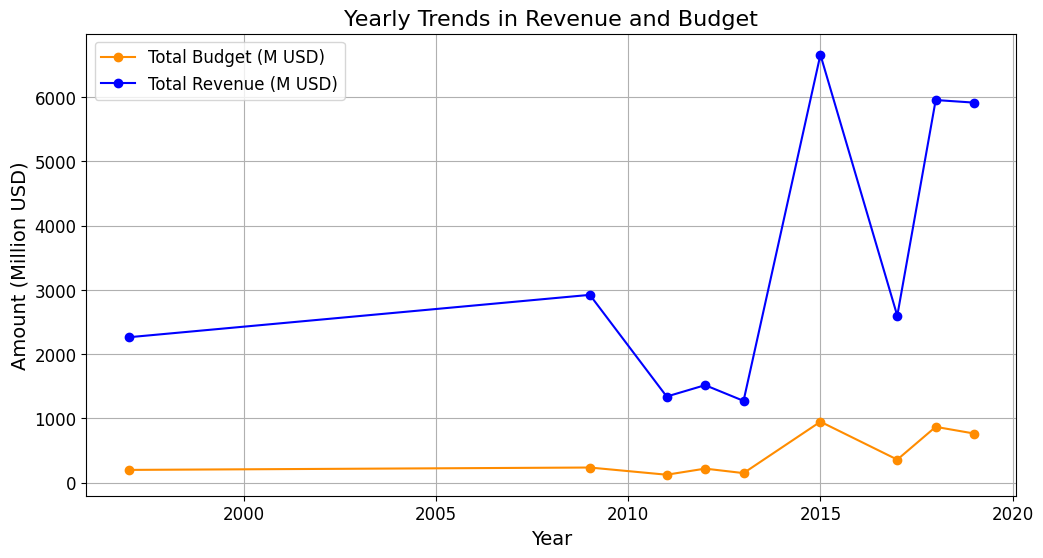

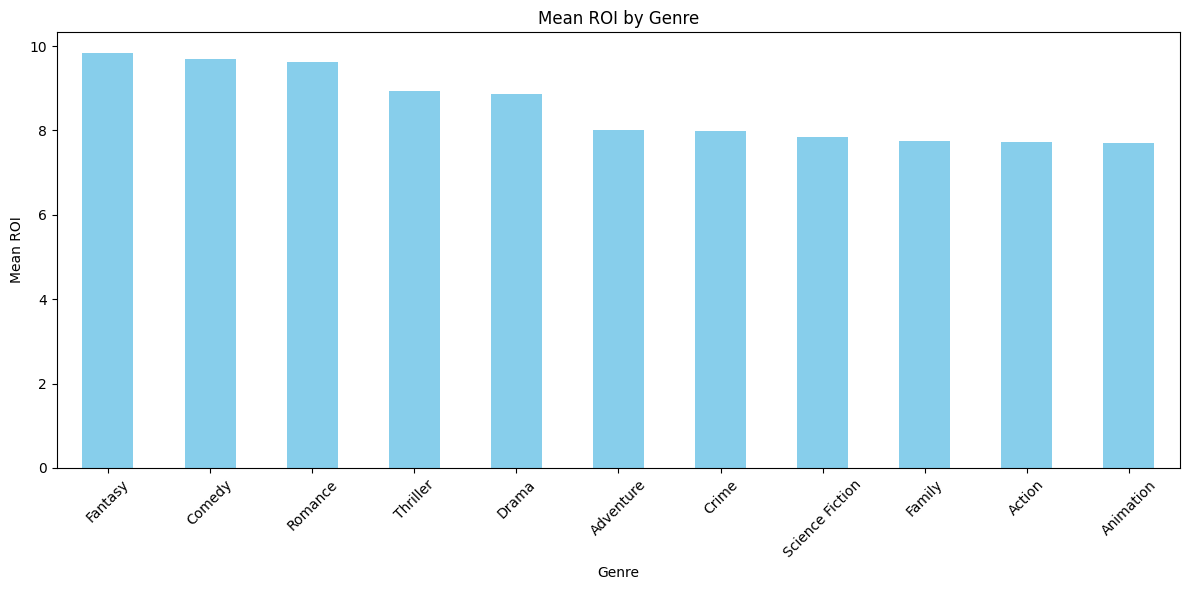

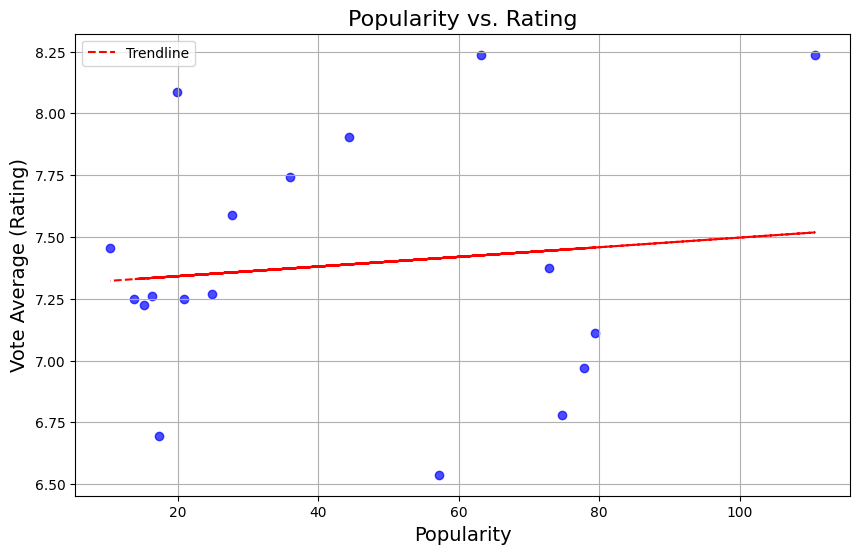

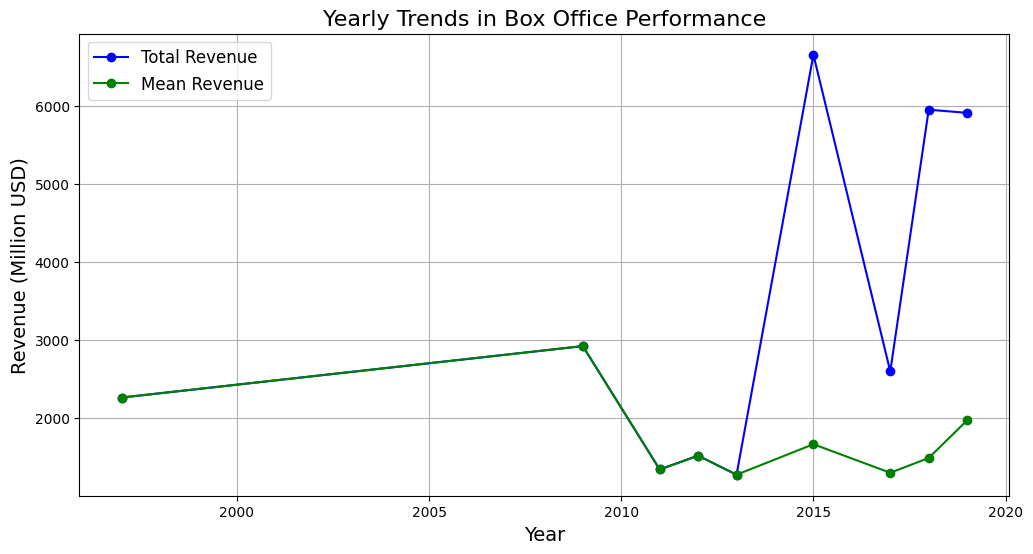

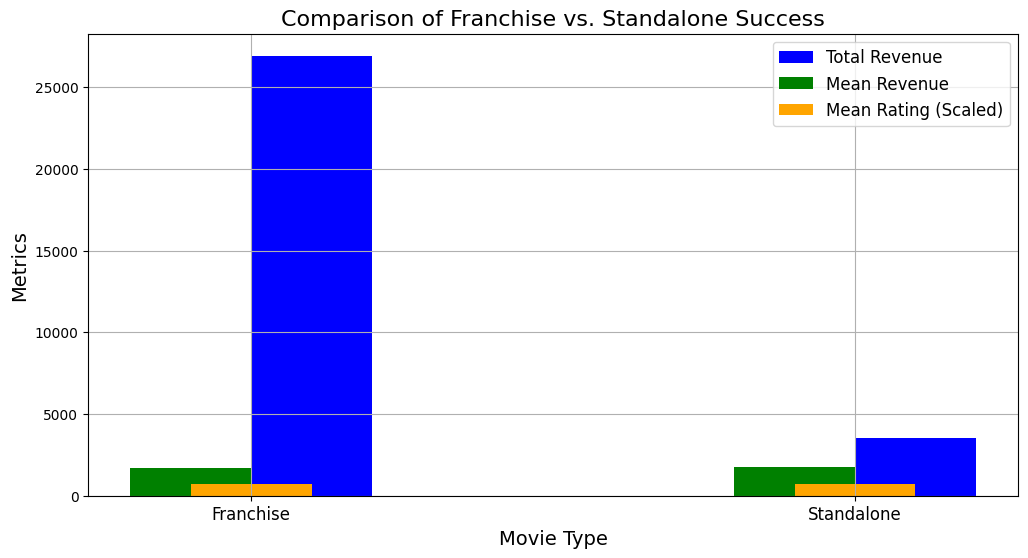

In [91]:
from src.all_graphs import plot_all_graphs

# Pass your cleaned_movies_df to generate all graphs
plot_all_graphs(cleaned_movies_df)
